In [8]:
!pip install numpy requests beautifulsoup4 pillow imagehash matplotlib pandas torch torchvision tqdm scikit-learn


# Блок 1: Основные импорты
import os
import random
import csv
import numpy as np
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlencode, urlparse, parse_qs
import shutil
import time
from io import BytesIO

# Блок 2: Работа с изображениями
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageEnhance
import imagehash

# Блок 3: Визуализация
import matplotlib.pyplot as plt

# Блок 4: Работа с данными
import pandas as pd
from collections import defaultdict

# Блок 5: PyTorch и машинное обучение
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import models, transforms

# Блок 6: Инструменты для машинного обучения
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

## Создание синтетических изображений

Изначально код создавался для генерации синтетики с добавлением лейблов на цифры и обучении йолы, в нашем же случае мы не будем использовать созданные метки.

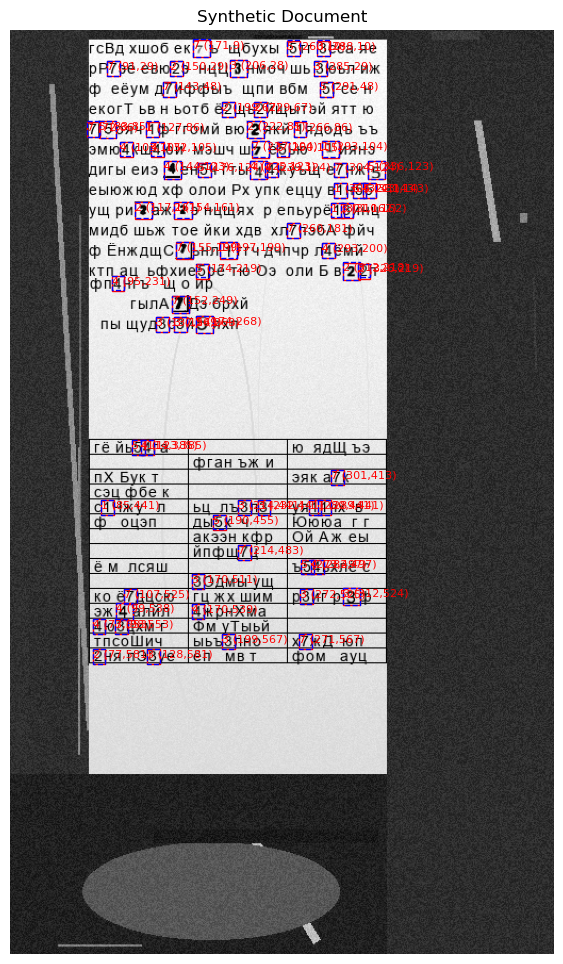

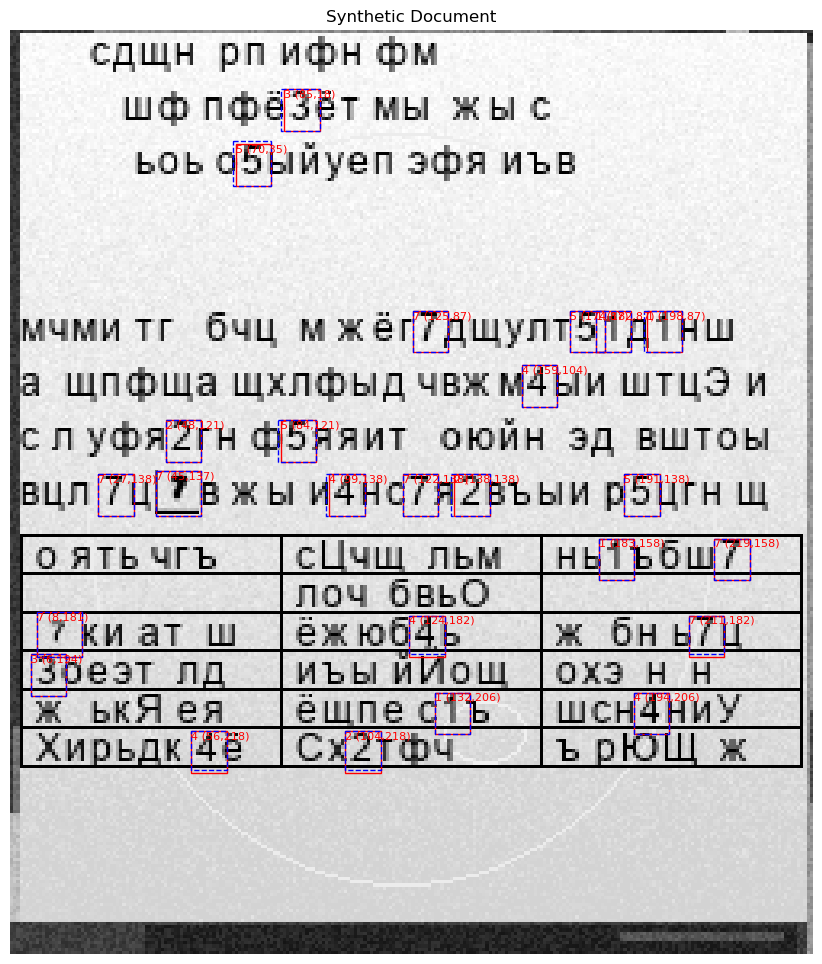

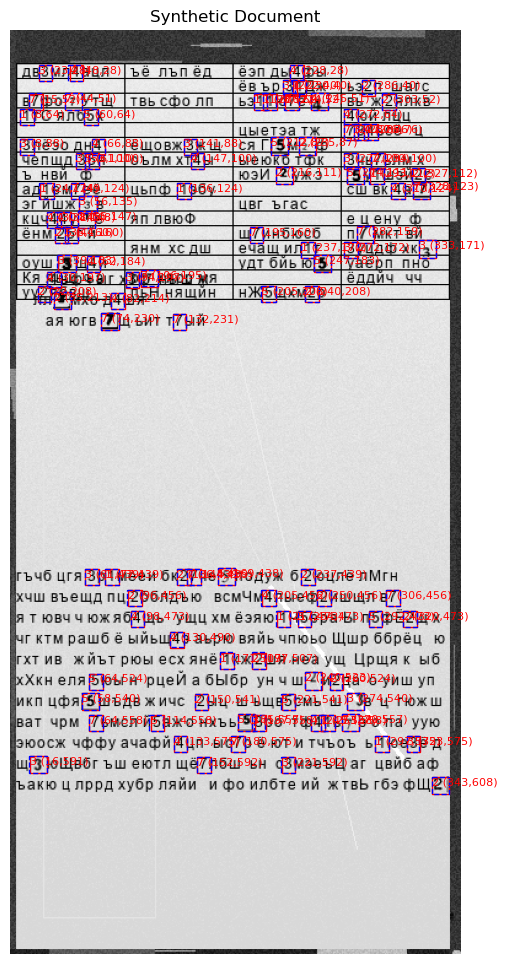

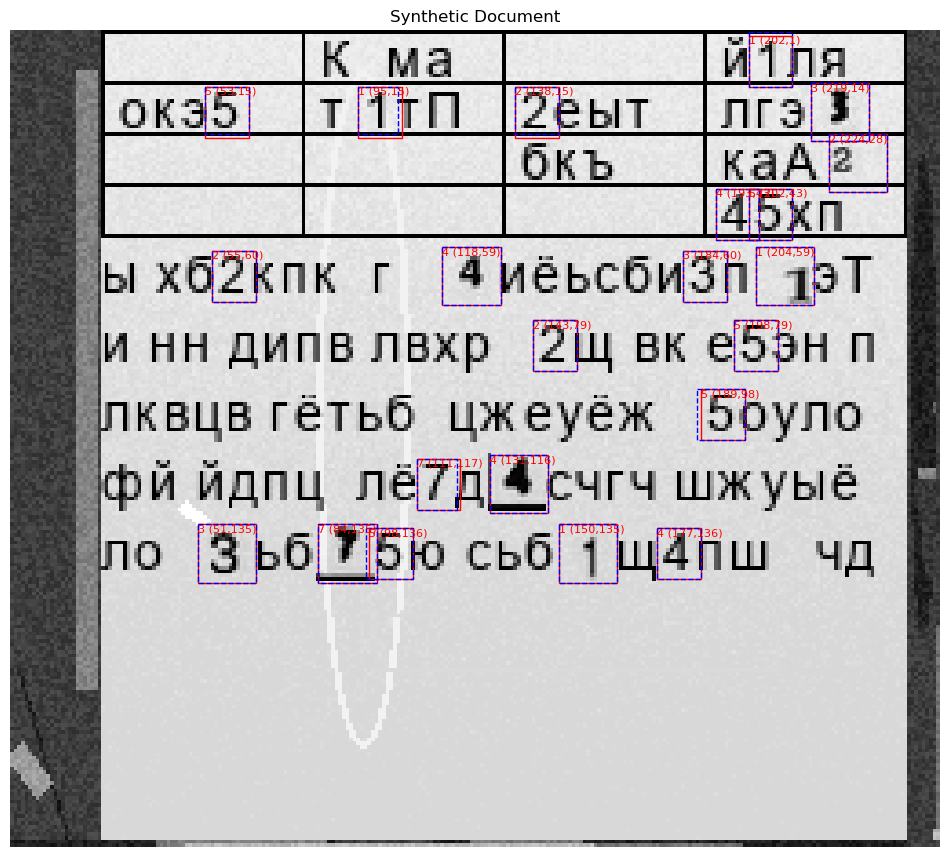

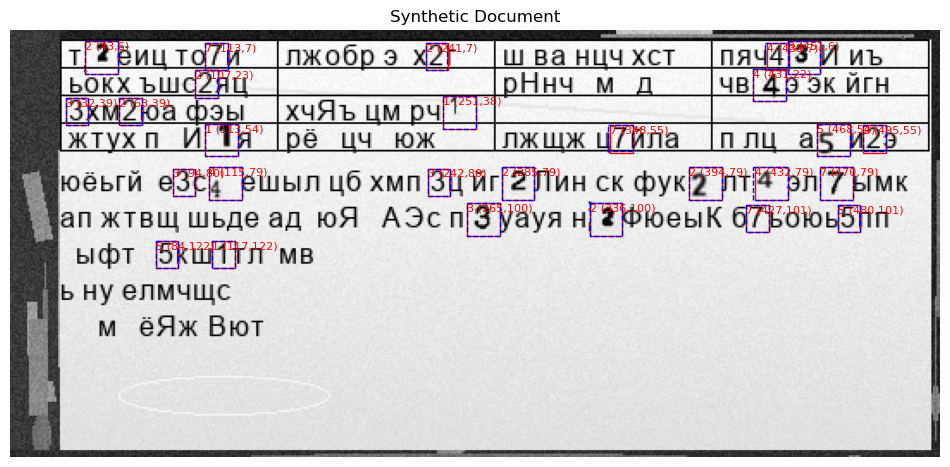

Generated 5 images and labels in YOLO format
CSV file with labels saved to train_synt\train_labels.csv


In [2]:
class SyntheticDocumentGenerator:
    """
    Генератор синтетических документов.
    
    При запуске кода для каждого генерируемого изображения происходят следующие шаги:
    
    1. Определение размеров документа:
       - Выбираются случайные значения для ширины и высоты документа (от 220 до 1000 пикселей).
       - Определяются размеры области содержимого (меньше или равны размерам документа).
    
    2. Создание фона документа:
       - Генерируется основной белый фон документа.
       - Создается фон области содержимого, имитирующий бумагу, с использованием градиентов и шума.
       - Генерируются и добавляются отступы с разнообразным фоном вокруг области содержимого.
    
    3. Добавление случайных геометрических фигур:
       - На область содержимого добавляются случайные линии, прямоугольники или эллипсы для имитации различных элементов документа.
    
    4. Генерация содержимого документа:
       - Выбирается случайное количество компонентов (от 2 до 3) из списка: текст, таблица, нижний колонтитул.
       - Для каждого выбранного компонента:
         а) Если это текст: генерируется случайный русский текст, возможно с добавлением чисел.
         б) Если это таблица: создается структура таблицы и заполняется случайным содержимым.
         в) Если это нижний колонтитул: добавляются несколько строк текста в нижней части документа.
    
    5. Добавление чисел:
       - В процессе генерации текста с вероятностью 10% добавляются числа.
       - Числа могут быть добавлены как текст или как изображения (с вероятностью 25%).
    
    6. Создание меток:
       - Для каждого добавленного числа создается метка с координатами его расположения на изображении.
    
    7. Преобразование меток:
       - Метки преобразуются в формат YOLO (класс, центр x, центр y, ширина, высота).
    
    8. Сохранение результатов:
       - Сгенерированное изображение сохраняется в формате PNG.
       - Метки сохраняются в текстовом файле в формате YOLO.
       - Информация о метках также записывается в CSV файл.
    
    9. Визуализация результата:
       - Созданное изображение отображается с наложенными на него метками для визуальной проверки.
    
    Этот процесс повторяется для каждого изображения в наборе данных, создавая разнообразные синтетические документы с соответствующими метками.
    """
    
    def __init__(self, number_images_folder='num', padding_percent=0.05):
        """
        Инициализирует генератор синтетических документов.
        
        :param number_images_folder: Папка с изображениями цифр
        :param padding_percent: Процент отступа для цифр
        """
        self.number_images = self.load_number_images(number_images_folder)
        self.padding_percent = padding_percent

    @staticmethod
    def create_paper_background(size, base_color=None):
        """
        Создает фоновое изображение, имитирующее бумагу.
        
        :param size: Размер изображения
        :param base_color: Базовый цвет бумаги
        :return: Изображение фона
        """
        width, height = size
        
        if base_color is None:
            base_color = np.random.randint(220, 250)
        
        gradient = np.linspace(0, 1, height)[:, np.newaxis]
        gradient = np.tile(gradient, (1, width))
        
        noise = np.random.normal(0, 0.1, (height, width))
        gradient += noise
        gradient = np.clip(gradient, 0, 1)
        
        color_range = np.random.randint(20, 40)
        background = base_color - gradient * color_range
        
        texture = np.random.randint(0, 10, (height, width))
        background -= texture
        
        background = np.clip(background, 200, 255).astype(np.uint8)
        
        return Image.fromarray(background, mode='L')

    @staticmethod
    def load_number_images(main_folder):
        """
        Загружает изображения цифр из указанной папки.
        
        :param main_folder: Главная папка с изображениями цифр
        :return: Словарь с изображениями цифр
        """
        number_images = {}
        for num in [1, 2, 3, 4, 5, 7]:
            folder_path = os.path.join(main_folder, str(num))
            if os.path.exists(folder_path):
                number_images[num] = [
                    SyntheticDocumentGenerator.crop_image(Image.open(os.path.join(folder_path, f)).convert('L'))
                    for f in os.listdir(folder_path)
                    if f.endswith(('.png', '.jpg', '.jpeg'))
                ]
        return number_images

    @staticmethod
    def crop_image(img):
        """
        Обрезает изображение, удаляя 10% с каждой стороны.
        
        :param img: Исходное изображение
        :return: Обрезанное изображение
        """
        width, height = img.size
        crop_amount = int(min(width, height) * 0.1)
        return img.crop((crop_amount, crop_amount, width - crop_amount, height - crop_amount))

    def add_random_shapes(self, draw, width, height, offset_x=0, offset_y=0):
        """
        Добавляет случайные геометрические фигуры на изображение.
        
        :param draw: Объект ImageDraw
        :param width: Ширина области рисования
        :param height: Высота области рисования
        :param offset_x: Смещение по X
        :param offset_y: Смещение по Y
        """
        for _ in range(random.randint(1, 5)):
            shape = random.choice(['line', 'rectangle', 'ellipse'])
            x1, y1 = random.randint(0, width), random.randint(0, height)
            x2, y2 = random.randint(0, width), random.randint(0, height)
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            color = random.randint(200, 240)
            if shape == 'line':
                draw.line([x1 + offset_x, y1 + offset_y, x2 + offset_x, y2 + offset_y], fill=color, width=random.randint(1, 3))
            elif shape == 'rectangle':
                draw.rectangle([x1 + offset_x, y1 + offset_y, x2 + offset_x, y2 + offset_y], outline=color, width=random.randint(1, 3))
            else:
                draw.ellipse([x1 + offset_x, y1 + offset_y, x2 + offset_x, y2 + offset_y], outline=color, width=random.randint(1, 3))

    def generate_random_russian_text(self, length, draw, x, y, font_size, max_width, offset_x=0, offset_y=0):
        """
        Генерирует случайный русский текст и рисует его на изображении.
        
        :param length: Длина текста
        :param draw: Объект ImageDraw
        :param x: Начальная X-координата
        :param y: Начальная Y-координата
        :param font_size: Размер шрифта
        :param max_width: Максимальная ширина текста
        :param offset_x: Смещение по X
        :param offset_y: Смещение по Y
        :return: Сгенерированный текст, метки и конечная X-координата
        """
        russian_letters = 'абвгдеёжийклмнопрстуфхцчшщъыьэюя'
        text = ''
        labels = []
        current_x = x + offset_x
        word_length = 0
    
        font = ImageFont.truetype("arial.ttf", font_size)
    
        i = 0
        while i < length and current_x < max_width + offset_x - font_size:
            if random.random() < 0.1:  # 10% chance to add a number
                num_text, num_labels, new_x = self.add_number(draw, current_x, y + offset_y, font, use_image=random.random() < 0.25)
                if new_x <= max_width + offset_x:
                    text += num_text
                    labels.extend(num_labels)
                    current_x = new_x
                word_length = 0
            else:
                if word_length >= random.randint(1, 7):
                    num_spaces = min(random.choices([1, 2, 3], weights=[0.7, 0.2, 0.1])[0], length - i)
                    space_bbox = font.getbbox(' ' * num_spaces)
                    space_width = space_bbox[2] - space_bbox[0]
                    if current_x + space_width <= max_width + offset_x:
                        text += ' ' * num_spaces
                        current_x += space_width
                        word_length = 0
                        i += num_spaces - 1
                    else:
                        break
                else:
                    char = random.choice(russian_letters)
                    if random.random() < 0.05:
                        char = char.upper()
                    char_bbox = font.getbbox(char)
                    char_width = char_bbox[2] - char_bbox[0]
                    if current_x + char_width <= max_width + offset_x:
                        text += char
                        draw.text((current_x, y + offset_y), char, fill=0, font=font)
                        current_x += char_width + 1
                        word_length += 1
                    else:
                        break
            i += 1
    
        return text, labels, current_x - offset_x

    def add_number(self, draw, x, y, font, use_image=False):
        """
        Добавляет число на изображение, используя либо изображение цифры, либо рисуя текст.
        
        :param draw: Объект ImageDraw
        :param x: X-координата
        :param y: Y-координата
        :param font: Шрифт для рисования текста
        :param use_image: Использовать изображение цифры вместо текста
        :return: Добавленное число, метки и конечная X-координата
        """
        num = random.choice([1, 2, 3, 4, 5, 7])
        
        box_adjust_x = -2
        box_adjust_y = 1
        box_adjust_width = 2
        box_adjust_height = 2
    
        if use_image and self.number_images and num in self.number_images:
            img = random.choice(self.number_images[num])
            img_width, img_height = img.size
            aspect_ratio = img_width / img_height
            new_height = int(font.size * 1.2)
            new_width = int(new_height * aspect_ratio)
            img = img.resize((new_width, new_height), Image.LANCZOS)
            img = ImageOps.invert(img)
            
            draw.bitmap((x, y), img, fill=0)
    
            box_x = x 
            box_y = y 
            box_width = new_width
            box_height = new_height
    
            return str(num), [(num, box_x, box_y, box_x + box_width, box_y + box_height)], x + new_width
        else:
            text = str(num)
            labels = []
            current_x = x
            total_width = 0
    
            for digit in text:
                bbox = font.getbbox(digit)
                digit_width = bbox[2] - bbox[0]
                digit_height = bbox[3] - bbox[1]
                
                padding = max(1, int(font.size * self.padding_percent))
                
                draw.text((current_x, y), digit, fill=0, font=font)
    
                box_x = current_x + box_adjust_x
                box_y = y + box_adjust_y
                box_width = digit_width + 2 * padding + box_adjust_width
                box_height = digit_height + 2 * padding + box_adjust_height
                
                labels.append((int(digit), box_x, box_y, box_x + box_width, box_y + box_height))
                
                current_x += digit_width + padding
                total_width += digit_width + padding
    
            return text, labels, x + total_width

    def generate_diverse_template(self, draw, content_width, content_height, offset_x=0, offset_y=0):
        """
        Генерирует разнообразный шаблон документа с различными компонентами.
        
        :param draw: Объект ImageDraw
        :param content_width: Ширина содержимого
        :param content_height: Высота содержимого
        :param offset_x: Смещение по X
        :param offset_y: Смещение по Y
        :return: Список меток сгенерированных элементов
        """
        font_size = int(random.randint(12, 16) * 1)
        labels = []

        components = ['text', 'table', 'footer']
        random.shuffle(components)

        num_components = random.randint(2, 3)
        selected_components = components[:num_components]

        total_height = content_height
        component_heights = [random.randint(total_height // (num_components * 2), total_height // num_components) for _ in range(num_components)]
        
        while sum(component_heights) > total_height:
            index = random.randint(0, num_components - 1)
            if component_heights[index] > total_height // (num_components * 2):
                component_heights[index] -= 1

        current_y = 0
        for component, height in zip(selected_components, component_heights):
            area = (0, current_y, content_width, current_y + height)
            
            if component == 'text':
                labels.extend(self.generate_text_content(draw, area, font_size, offset_x, offset_y))
            elif component == 'table':
                labels.extend(self.generate_table_content(draw, area, font_size, offset_x, offset_y))
            elif component == 'footer':
                labels.extend(self.add_footer(draw, area, font_size, offset_x, offset_y))
            
            current_y += height

        return labels

    def add_footer(self, draw, area, font_size, offset_x=0, offset_y=0):
        """
        Добавляет нижний колонтитул на документ.
        
        :param draw: Объект ImageDraw
        :param area: Область для рисования
        :param font_size: Размер шрифта
        :param offset_x: Смещение по X
        :param offset_y: Смещение по Y
        :return: Список меток элементов нижнего колонтитула
        """
        x1, y1, x2, y2 = area
        font = ImageFont.truetype("arial.ttf", font_size)
        y = y1
        all_labels = []
        for _ in range(3):
            x = random.randint(x1, x1 + 40) + offset_x
            text, labels, _ = self.generate_random_russian_text(random.randint(10, 20), draw, x - offset_x, y - offset_y, font_size, x2 - x, offset_x, offset_y)
            all_labels.extend(labels)
            y += font_size + 5
        return all_labels

    def generate_text_content(self, draw, area, font_size, offset_x=0, offset_y=0):
        """
        Генерирует текстовое содержимое для документа.
        
        :param draw: Объект ImageDraw
        :param area: Область для рисования
        :param font_size: Размер шрифта
        :param offset_x: Смещение по X
        :param offset_y: Смещение по Y
        :return: Список меток текстовых элементов
        """
        x1, y1, x2, y2 = area
        y = y1
        labels = []
        while y < y2 - font_size:
            line_length = random.randint(40, 80)
            text, line_labels, end_x = self.generate_random_russian_text(line_length, draw, x1, y, font_size, x2 - x1, offset_x, offset_y)
            labels.extend(line_labels)
            y += font_size + 5
        return labels
        
    def generate_table_content(self, draw, area, font_size, offset_x=0, offset_y=0):
        """
        Генерирует содержимое таблицы для документа.
        
        :param draw: Объект ImageDraw
        :param area: Область для рисования таблицы
        :param font_size: Размер шрифта
        :param offset_x: Смещение по X
        :param offset_y: Смещение по Y
        :return: Список меток элементов таблицы
        """
        x1, y1, x2, y2 = area
        num_columns = random.randint(3, 5)
        cell_width = (x2 - x1) // num_columns
        cell_height = int(font_size * 1)
        num_rows = (y2 - y1) // cell_height
        font = ImageFont.truetype("arial.ttf", font_size)
        labels = []
    
        for i in range(num_rows):
            for j in range(num_columns):
                x = x1 + j * cell_width + offset_x
                y = y1 + i * cell_height + offset_y
                draw.rectangle([x, y, x + cell_width, y + cell_height], outline=0)
    
                if random.random() < 0.7:  # 70% вероятность заполнения ячейки
                    max_chars = max(1, int((cell_width - 10) / (font_size * 0.6)))
                    cell_content, cell_labels, end_x = self.generate_random_russian_text(
                        max_chars,
                        draw,
                        x + 5 - offset_x,
                        y + (cell_height - font_size) // 2 - offset_y,
                        font_size,
                        x + cell_width - 5 - offset_x,
                        offset_x,
                        offset_y
                    )
                    labels.extend(cell_labels)
    
        return labels


    def create_synthetic_document(self):
        """
        Создает синтетический документ с случайным содержимым.
        
        :return: Изображение документа и список меток элементов
        """
        # Generate random width and height between 220 and 1200
        document_width = random.randint(220, 1000)
        document_height = random.randint(220, 1000)
        
        # Decide on content area size (smaller than or equal to document size)
        content_width = random.randint(220, min(document_width, 800))
        content_height = random.randint(220, min(document_height, 800))
        
        # Calculate maximum possible padding
        max_padding_x = document_width - content_width
        max_padding_y = document_height - content_height
        
        # Determine random padding (can be zero)
        actual_padding_x = random.randint(0, max_padding_x)
        actual_padding_y = random.randint(0, max_padding_y)
        
        # Determine padding distribution
        left_padding = int(actual_padding_x * random.uniform(0, 1))
        right_padding = actual_padding_x - left_padding
        top_padding = int(actual_padding_y * random.uniform(0, 1))
        bottom_padding = actual_padding_y - top_padding
        
        # Calculate final document size
        final_width = content_width + left_padding + right_padding
        final_height = content_height + top_padding + bottom_padding
        
        # Create document background (white)
        document_background = Image.new('L', (final_width, final_height), color=255)
        
        # Create content background
        content_background = self.create_paper_background((content_width, content_height))
        
        # Create gray background for padding areas
        if left_padding > 0:
            left_bg = self.create_diverse_padding_background(left_padding, final_height)
            document_background.paste(left_bg, (0, 0))
        if top_padding > 0:
            top_bg = self.create_diverse_padding_background(final_width - left_padding, top_padding)
            document_background.paste(top_bg, (left_padding, 0))
        if right_padding > 0:
            right_bg = self.create_diverse_padding_background(right_padding, final_height - top_padding)
            document_background.paste(right_bg, (final_width - right_padding, top_padding))
        if bottom_padding > 0:
            bottom_bg = self.create_diverse_padding_background(final_width - right_padding, bottom_padding)
            document_background.paste(bottom_bg, (0, final_height - bottom_padding))
        
        # Paste content background onto document background
        document_background.paste(content_background, (left_padding, top_padding))
        
        # Create draw object for the document
        draw = ImageDraw.Draw(document_background)
        
        # Add random shapes to the content area
        self.add_random_shapes(draw, content_width, content_height, offset_x=left_padding, offset_y=top_padding)
        
        # Generate labels, adjusting for the padding
        labels = self.generate_diverse_template(draw, content_width, content_height, offset_x=left_padding, offset_y=top_padding)
        
        return document_background, labels


    def convert_to_yolo_format(self, label, image_width, image_height):
        """
        Преобразует метки в формат YOLO.
        
        :param label: Метка в исходном формате
        :param image_width: Ширина изображения
        :param image_height: Высота изображения
        :return: Метка в формате YOLO
        """
        num, x1, y1, x2, y2 = label
        x_center = (x1 + x2) / (2 * image_width)
        y_center = (y1 + y2) / (2 * image_height)
        width = (x2 - x1) / image_width
        height = (y2 - y1) / image_height
        # Преобразуем числа в соответствующие классы
        class_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
        class_num = class_map[num]
        return class_num, x_center, y_center, width, height

    def display_document(self, image, labels):
        """
        Отображает сгенерированный документ с метками.
        
        :param image: Изображение документа
        :param labels: Список меток
        """
        plt.figure(figsize=(12, 12))
        plt.imshow(image, cmap='gray')
        plt.title("Synthetic Document")
        
        for label in labels:
            num, x1, y1, x2, y2 = label
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red')
            plt.gca().add_patch(rect)
            plt.text(x1, y1, f"{num} ({x1},{y1})", color='red', fontsize=8, verticalalignment='top')
            
            # Отображение YOLO-координат
            img_width, img_height = image.size
            yolo_label = self.convert_to_yolo_format(label, img_width, img_height)
            yolo_num, yolo_x, yolo_y, yolo_w, yolo_h = yolo_label
            yolo_x1 = int((yolo_x - yolo_w/2) * img_width)
            yolo_y1 = int((yolo_y - yolo_h/2) * img_height)
            yolo_x2 = int((yolo_x + yolo_w/2) * img_width)
            yolo_y2 = int((yolo_y + yolo_h/2) * img_height)
            
            rect_yolo = plt.Rectangle((yolo_x1, yolo_y1), yolo_x2-yolo_x1, yolo_y2-yolo_y1, 
                                      fill=False, edgecolor='blue', linestyle='--')
            plt.gca().add_patch(rect_yolo)
        
        plt.axis('off')
        plt.show()

    def generate_dataset(self, num_images, output_folder, csv_filename):
        """
        Генерирует набор данных из синтетических документов.
        
        :param num_images: Количество изображений для генерации
        :param output_folder: Папка для сохранения результатов
        :param csv_filename: Имя файла CSV для сохранения меток
        """
        os.makedirs(output_folder, exist_ok=True)
        images_folder = os.path.join(output_folder, 'images')
        os.makedirs(images_folder, exist_ok=True)
        labels_folder = os.path.join(output_folder, 'labels')
        os.makedirs(labels_folder, exist_ok=True)
        csv_path = os.path.join(output_folder, csv_filename)
        
        with open(csv_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['image_name', 'number', 'x1', 'y1', 'x2', 'y2'])
            
            for i in range(num_images):
                image, labels = self.create_synthetic_document()
                
                image_name = f"synthetic_doc_{i:04d}.png"
                label_name = f"synthetic_doc_{i:04d}.txt"
                image_path = os.path.join(images_folder, image_name)
                label_path = os.path.join(labels_folder, label_name)
                
                image.save(image_path)
                
                with open(label_path, 'w') as f:
                    for label in labels:
                        num, x1, y1, x2, y2 = label
                        csv_writer.writerow([image_name, num, x1, y1, x2, y2])
                        
                        yolo_label = self.convert_to_yolo_format(label, image.width, image.height)
                        class_num, x_center, y_center, width, height = yolo_label
                        f.write(f"{class_num} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                
                self.display_document(image, labels)
        
        print(f"Generated {num_images} images and labels in YOLO format")
        print(f"CSV file with labels saved to {csv_path}")

    def create_diverse_padding_background(self, width, height):
        """
        Создает разнообразный фон для отступов документа.
        
        :param width: Ширина фона
        :param height: Высота фона
        :return: Изображение фона для отступов
        """
        # Create a base dark gray background
        background = Image.new('L', (width, height), color=random.randint(30, 60))
        draw = ImageDraw.Draw(background)
        
        # Add irregular light and dark areas
        num_shapes = random.randint(3, 7)
        for _ in range(num_shapes):
            shape_type = random.choice(['rectangle', 'ellipse', 'line'])
            x1 = random.randint(0, width)
            y1 = random.randint(0, height)
            x2 = random.randint(x1, width)
            y2 = random.randint(y1, height)
            
            color = random.randint(20, 100)  # Darker shades
            if random.random() < 0.5:  # 20% chance for a lighter area
                color = random.randint(101, 180)
            
            if shape_type == 'rectangle':
                draw.rectangle([x1, y1, x2, y2], fill=color)
            elif shape_type == 'ellipse':
                draw.ellipse([x1, y1, x2, y2], fill=color)
            else:  # line
                draw.line([x1, y1, x2, y2], fill=color, width=random.randint(1, 10))

        # Add some noise
        pixels = background.load()
        for i in range(width):
            for j in range(height):
                noise = random.randint(-15, 15)
                pixels[i, j] = max(0, min(255, pixels[i, j] + noise))

        return background

if __name__ == "__main__":
    generator = SyntheticDocumentGenerator()
    generator.generate_dataset(5, "train_synt", "train_labels.csv")


## Скачиваем реальные изображения

Было скачено около 700 изображений.

In [4]:
def download_similar_images(url, num_images):
    # Разбор URL для извлечения необходимых параметров
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    
    base_url = "https://yandex.ru/images/search"
    params = {
        "cbir_id": query_params.get("cbir_id", [""])[0],
        "rpt": "imageview",
        "cbir_page": "similar",
        "p": 0,
    }
    
    folder_name = "similar_images"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    downloaded = 0
    page = 0
    
    while downloaded < num_images:
        params["p"] = page
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        response = requests.get(base_url, params=params, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        image_links = soup.find_all('img', class_='serp-item__thumb')
        
        if not image_links:
            print(f"Больше изображений не найдено. Всего скачано: {downloaded}")
            break
        
        for img in image_links:
            if downloaded >= num_images:
                break
            
            img_url = img.get('src')
            if not img_url:
                continue
            if not img_url.startswith('http'):
                img_url = 'https:' + img_url
            
            try:
                img_data = requests.get(img_url, timeout=10, headers=headers).content
                with open(f'{folder_name}/{downloaded+1}.jpg', 'wb') as handler:
                    handler.write(img_data)
                downloaded += 1
                print(f"Скачано изображение {downloaded}/{num_images}")
            except Exception as e:
                print(f"Ошибка при скачивании изображения: {e}")
            
            time.sleep(0.5)  # Небольшая задержка между запросами
        
        page += 1
        time.sleep(2)  # Задержка между страницами
    
    print(f"Всего скачано {downloaded} изображений")

# Пример использования
url = "https://yandex.ru/images/search?cbir_id=7734805%2FJ3V0WlSqEv4xpXoehZ8pqQ9850&cbir_page=similar&from=tabbar&rpt=imageview&source-serpid=2hQYFZSDrnldTcCCIE8w2A&url=https%3A%2F%2Favatars.mds.yandex.net%2Fget-images-cbir%2F7734805%2FJ3V0WlSqEv4xpXoehZ8pqQ9850%2Forig"
download_similar_images(url, 10)

Скачано изображение 1/10
Скачано изображение 2/10
Скачано изображение 3/10
Скачано изображение 4/10
Скачано изображение 5/10
Скачано изображение 6/10
Скачано изображение 7/10
Скачано изображение 8/10
Скачано изображение 9/10
Скачано изображение 10/10
Всего скачано 10 изображений


In [6]:
# Удалим дубликаты
# Путь к папке с изображениями
folder_path = r'C:\Users\user\similar_images'

# Словарь для хранения хешей изображений
hash_dict = defaultdict(list)

# Проходим по всем файлам в папке
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        file_path = os.path.join(folder_path, filename)
        try:
            # Открываем изображение
            with Image.open(file_path) as img:
                # Вычисляем хеш изображения
                hash = str(imagehash.average_hash(img))
                # Добавляем полный путь к файлу к соответствующему хешу
                hash_dict[hash].append(file_path)
        except Exception as e:
            print(f"Ошибка при обработке {filename}: {e}")

# Счетчик удаленных дубликатов
removed_count = 0

# Удаляем дубликаты
for hash, file_paths in hash_dict.items():
    if len(file_paths) > 1:
        # Оставляем первый файл, удаляем остальные
        for file_path in file_paths[1:]:
            try:
                os.remove(file_path)
                removed_count += 1
                print(f"Удален дубликат: {file_path}")
            except Exception as e:
                print(f"Ошибка при удалении {file_path}: {e}")

# Выводим общее количество удаленных дубликатов
print(f"\nОбщее количество удаленных дубликатов: {removed_count}")


Общее количество удаленных дубликатов: 0


## Создание датасета

In [1]:
def process_and_rotate_images(base_path):
    """
    Обрабатывает изображения в базовой директории, поворачивает их и распределяет по папкам классов.
    
    :param base_path: Путь к базовой директории с изображениями
    """
    # Создаем папки для классов, если они не существуют
    class_folders = ['class_0', 'class_90', 'class_180', 'class_270']
    for folder in class_folders:
        os.makedirs(os.path.join(base_path, folder), exist_ok=True)
    
    # Обрабатываем каждое изображение в базовой директории
    for filename in tqdm(os.listdir(base_path), desc="Processing images"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(base_path, filename)
            try:
                with Image.open(img_path) as img:
                    # Обрабатываем для class_0 (оригинал)
                    img = img.convert('L')  # Преобразуем в оттенки серого
                    img = img.resize((512, 512))  # Изменяем размер на 512x512
                    img.save(os.path.join(base_path, 'class_0', filename.replace('.png', '.jpg')))
                    
                    # Обрабатываем для class_90 (повернуто на 90 градусов)
                    img_90 = img.rotate(-90, expand=True)
                    img_90.save(os.path.join(base_path, 'class_90', filename.replace('.png', '.jpg')))
                    
                    # Обрабатываем для class_180 (повернуто на 180 градусов)
                    img_180 = img.rotate(-180, expand=True)
                    img_180.save(os.path.join(base_path, 'class_180', filename.replace('.png', '.jpg')))
                    
                    # Обрабатываем для class_270 (повернуто на 270 градусов)
                    img_270 = img.rotate(-270, expand=True)
                    img_270.save(os.path.join(base_path, 'class_270', filename.replace('.png', '.jpg')))
                
                # Удаляем оригинальный PNG-файл
                os.remove(img_path)
            except IOError:
                print(f"Error processing image: {filename}")

def create_correct_csv(base_path, csv_path):
    """
    Создает корректный CSV-файл на основе структуры папок и изображений.
    
    :param base_path: Путь к базовой директории с папками классов
    :param csv_path: Путь для сохранения CSV-файла
    """
    import csv
    
    # Словарь для соответствия имен папок и меток классов
    class_to_label = {
        'class_0': 0,
        'class_90': 1,
        'class_180': 2,
        'class_270': 3
    }
    
    data = []
    
    # Проходим по всем классам и их изображениям
    for class_name, label in tqdm(class_to_label.items(), desc="Processing classes"):
        class_folder = os.path.join(base_path, class_name)
        
        for filename in os.listdir(class_folder):
            if filename.lower().endswith('.jpg'):
                relative_path = os.path.join(class_name, filename)
                full_path = os.path.join(base_path, relative_path)
                
                try:
                    # Проверяем размер и тип изображения
                    with Image.open(full_path) as img:
                        if img.size != (512, 512) or img.mode != 'L':
                            print(f"Warning: Image {full_path} is not 512x512 or not grayscale. Skipping.")
                            continue
                    
                    data.append([relative_path, label])
                except IOError:
                    print(f"Warning: Cannot open {full_path} as an image. Skipping.")
    
    # Записываем данные в CSV-файл
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['image', 'label'])
        writer.writerows(data)
    
    print(f"CSV file created successfully. Total entries: {len(data)}")

In [7]:
def process_dataset(base_path, dataset_name):
    """
    Обрабатывает заданный набор данных: поворачивает изображения и создает CSV-файл.
    
    :param base_path: Базовый путь к набору данных
    :param dataset_name: Имя набора данных (для вывода)
    """
    csv_path = os.path.join(base_path, 'image_labels.csv')
    
    print(f"Обработка набора данных: {dataset_name}")
    print("Поворот изображений...")
    process_and_rotate_images(base_path)
    
    print("Создание CSV-файла...")
    create_correct_csv(base_path, csv_path)
    
    print(f"Обработка {dataset_name} завершена.\n")

# Определение путей к наборам данных
datasets = {
    'train_synt': r'C:\Users\user\mobil\train_synt',
    'train_real': r'C:\Users\user\mobil\train_real',
    'test': r'C:\Users\user\mobil\test'
}

# Обработка каждого набора данных
for dataset_name, base_path in datasets.items():
    process_dataset(base_path, dataset_name)

print("Все наборы данных обработаны.")

Processing classes: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

CSV file created successfully. Total entries: 692


## загрузка данных для обучения модели

In [4]:
def load_data(data_dir):
    """ Загружает данные из CSV-файла и проверяет целостность изображений.
    :param data_dir: Путь к директории с данными """
    csv_path = os.path.join(data_dir, 'image_labels.csv')
    
    # Проверка наличия CSV-файла
    if not os.path.exists(csv_path):
        print(f"Ошибка: Не удалось найти image_labels.csv в {data_dir}")
        print(f"Файлы в директории: {os.listdir(data_dir)}")
        return None
    
    print(f"Загрузка данных из: {csv_path}")
    
    # Чтение CSV-файла
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Ошибка при чтении CSV-файла: {e}")
        return None
    
    # Вывод информации о загруженных данных
    print(f"Всего строк в CSV: {len(df)}")
    print(f"Столбцы CSV: {df.columns}")
    print(f"Первые несколько строк:\n{df.head()}")
    
    # Проверка структуры CSV
    if 'image' not in df.columns or 'label' not in df.columns:
        print("Ошибка: CSV-файл не содержит ожидаемых столбцов 'image' и 'label'.")
        return None
    
    # Проверка диапазона меток
    unique_labels = df['label'].unique()
    if not set(unique_labels).issubset({0, 1, 2, 3}):
        print(f"Предупреждение: Обнаружены неожиданные значения меток: {unique_labels}. Метки должны быть 0, 1, 2 или 3.")
    
    # Проверка существования файлов и свойств изображений
    tqdm.pandas(desc="Проверка файлов")
    df['file_status'] = df.progress_apply(lambda row: check_image(data_dir, row['image']), axis=1)
    
    # Удаление записей с отсутствующими или недействительными файлами
    invalid_files = df[df['file_status'] != 'valid']
    if not invalid_files.empty:
        print(f"Предупреждение: {len(invalid_files)} файлов изображений отсутствуют или недействительны и будут удалены из набора данных.")
        print("Пример недействительных файлов:")
        print(invalid_files.head())
        df = df[df['file_status'] == 'valid']
    
    df = df.drop('file_status', axis=1)
    
    print(f"Итоговое количество действительных изображений: {len(df)}")
    return df

def check_image(data_dir, image_path):
    """ Проверяет существование и свойства изображения.
    :param data_dir: Путь к директории с данными
    :param image_path: Путь к изображению """
    full_path = os.path.join(data_dir, image_path)
    if not os.path.exists(full_path):
        return f"не найдено: {full_path}"
    try:
        with Image.open(full_path) as img:
            if img.size != (512, 512):
                return f"неверный размер: {img.size}"
            if img.mode != 'L':
                return f"неверный режим: {img.mode}"
            return 'valid'
    except IOError as e:
        return f"ошибка ввода-вывода: {str(e)}"

class CertificateDataset(Dataset):
    """ Класс для создания набора данных сертификатов. """
    def __init__(self, data_dir, df, transform=None):
        """ Инициализация набора данных.
        :param data_dir: Путь к директории с данными
        :param df: DataFrame с информацией об изображениях
        :param transform: Преобразования для применения к изображениям """
        self.data_dir = data_dir
        self.df = df
        self.transform = transform
        print(f"Набор данных инициализирован с {len(self.df)} образцами")
        
        # Загрузка изображений
        self.images = []
        for idx in tqdm(range(len(self.df)), desc="Загрузка изображений"):
            self.images.append(self.load_image(idx))
        self.labels = torch.tensor(self.df['label'].values, dtype=torch.long)

    def __len__(self):
        """ Возвращает количество образцов в наборе данных. """
        return len(self.df)

    def load_image(self, idx):
        """ Загружает изображение по индексу.
        :param idx: Индекс изображения """
        img_name = self.df.iloc[idx]['image']
        img_path = os.path.join(self.data_dir, img_name)
        return Image.open(img_path).convert('L')  # Преобразование в оттенки серого

    def __getitem__(self, idx):
        """ Возвращает образец по индексу.
        :param idx: Индекс образца """
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Использование функций
base_dir = r'C:\Users\user\mobil'
train_synt_dir = os.path.join(base_dir, 'train_synt')
train_real_dir = os.path.join(base_dir, 'train_real')
test_dir = os.path.join(base_dir, 'test')

print("Загрузка синтетических тренировочных данных...")
train_synt_df = load_data(train_synt_dir)

print("\nЗагрузка реальных тренировочных данных...")
train_real_df = load_data(train_real_dir)

print("\nЗагрузка тестовых данных...")
test_df = load_data(test_dir)

# Проверка загруженных данных
if train_synt_df is None or train_real_df is None or test_df is None:
    print("Ошибка: Не удалось загрузить один или несколько наборов данных. Пожалуйста, проверьте сообщения об ошибках выше.")
else:
    print(f"\nКоличество синтетических тренировочных изображений: {len(train_synt_df)}")
    print(f"Количество реальных тренировочных изображений: {len(train_real_df)}")
    print(f"Количество тестовых изображений: {len(test_df)}")

    print("\nПример синтетических тренировочных данных:")
    print(train_synt_df.head())

    print("\nПример реальных тренировочных данных:")
    print(train_real_df.head())

    print("\nПример тестовых данных:")
    print(test_df.head())

    # Распределение классов
    print("\nРаспределение классов в синтетическом тренировочном наборе:")
    print(train_synt_df['label'].value_counts())

    print("\nРаспределение классов в реальном тренировочном наборе:")
    print(train_real_df['label'].value_counts())

    print("\nРаспределение классов в тестовом наборе:")
    print(test_df['label'].value_counts())

# Создание преобразований для аугментации данных
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

print("\nСоздание синтетического тренировочного набора данных...")
train_synt_dataset = CertificateDataset(train_synt_dir, train_synt_df, transform=train_transform)

print("\nСоздание реального тренировочного набора данных...")
train_real_dataset = CertificateDataset(train_real_dir, train_real_df, transform=train_transform)

print("\nСоздание тестового набора данных...")
test_dataset = CertificateDataset(test_dir, test_df, transform=test_transform)

# Объединение синтетических и реальных тренировочных наборов данных
train_dataset = ConcatDataset([train_synt_dataset, train_real_dataset])

print("Наборы данных успешно созданы.")

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Загрузчики данных созданы. Готовы к обучению и оценке модели.")

Loading synthetic training data...
Loading data from: C:\Users\user\mobil\train_synt\image_labels.csv
Total rows in CSV: 4000
CSV columns: Index(['image', 'label'], dtype='object')
First few rows:
                            image  label
0  class_0\synthetic_doc_0000.jpg      0
1  class_0\synthetic_doc_0001.jpg      0
2  class_0\synthetic_doc_0002.jpg      0
3  class_0\synthetic_doc_0003.jpg      0
4  class_0\synthetic_doc_0004.jpg      0


Checking files: 100%|██████████| 4000/4000 [00:02<00:00, 1530.85it/s]


Final number of valid images: 4000

Loading real training data...
Loading data from: C:\Users\user\mobil\train_real\image_labels.csv
Total rows in CSV: 2172
CSV columns: Index(['image', 'label'], dtype='object')
First few rows:
             image  label
0    class_0\1.jpg      0
1   class_0\10.jpg      0
2  class_0\100.jpg      0
3  class_0\101.jpg      0
4  class_0\102.jpg      0


Checking files: 100%|██████████| 2172/2172 [00:01<00:00, 1711.79it/s]


Final number of valid images: 2172

Loading test data...
Loading data from: C:\Users\user\mobil\test\image_labels.csv
Total rows in CSV: 692
CSV columns: Index(['image', 'label'], dtype='object')
First few rows:
                                               image  label
0  class_0\402___136d64ae8d174354bc2af057d77f93a7...      0
1  class_0\402___335f83b3a37b403fb31088c8132f74b4...      0
2  class_0\402___87e9b407c1e5485e9872ff3acf484731...      0
3  class_0\402___96f14679afdb4078bb277152b1b6c215...      0
4  class_0\402___fa2f8d33a9cc4318b720f1086df67e3a...      0


Checking files: 100%|██████████| 692/692 [00:00<00:00, 1634.48it/s]


Final number of valid images: 692

Number of synthetic training images: 4000
Number of real training images: 2172
Number of test images: 692

Sample of the synthetic training data:
                            image  label
0  class_0\synthetic_doc_0000.jpg      0
1  class_0\synthetic_doc_0001.jpg      0
2  class_0\synthetic_doc_0002.jpg      0
3  class_0\synthetic_doc_0003.jpg      0
4  class_0\synthetic_doc_0004.jpg      0

Sample of the real training data:
             image  label
0    class_0\1.jpg      0
1   class_0\10.jpg      0
2  class_0\100.jpg      0
3  class_0\101.jpg      0
4  class_0\102.jpg      0

Sample of the test data:
                                               image  label
0  class_0\402___136d64ae8d174354bc2af057d77f93a7...      0
1  class_0\402___335f83b3a37b403fb31088c8132f74b4...      0
2  class_0\402___87e9b407c1e5485e9872ff3acf484731...      0
3  class_0\402___96f14679afdb4078bb277152b1b6c215...      0
4  class_0\402___fa2f8d33a9cc4318b720f1086df67e3a...    

Loading images: 100%|██████████| 4000/4000 [00:04<00:00, 956.74it/s] 



Creating real training dataset...
Dataset initialized with 2172 samples


Loading images: 100%|██████████| 2172/2172 [00:01<00:00, 1162.82it/s]



Creating test dataset...
Dataset initialized with 692 samples


Loading images: 100%|██████████| 692/692 [00:00<00:00, 1190.53it/s]

Datasets created successfully.
DataLoaders created. Ready for model training and evaluation.


## обучение модели

In [2]:
def create_model():
    """
    Создает и инициализирует модель MobileNetV2 для классификации ориентации сертификатов.
    """
    # Загрузка предобученной модели MobileNetV2
    model = models.mobilenet_v2(pretrained=True)
    # Изменение первого сверточного слоя для работы с одноканальными изображениями
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    # Изменение последнего полносвязного слоя для классификации на 4 класса
    model.classifier[1] = nn.Linear(model.last_channel, 4)
    # Перемещение модели на доступное устройство (GPU или CPU)
    return model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

class EarlyStopping:
    """
    Класс для реализации ранней остановки обучения.
    Останавливает обучение, если производительность на валидационном наборе не улучшается в течение заданного количества эпох.
    """
    def __init__(self, patience=7, min_delta=0):
        self.patience, self.min_delta = patience, min_delta
        self.counter, self.best_score, self.early_stop = 0, None, False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score, self.counter = score, 0

def train_evaluate(model, data_loader, criterion, optimizer=None, device=None):
    """
    Выполняет одну эпоху обучения или оценки модели.
    """
    # Установка режима обучения или оценки
    model.train() if optimizer else model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_predictions = [], []

    with torch.set_grad_enabled(optimizer is not None):
        for inputs, labels in tqdm(data_loader, desc="Обучение" if optimizer else "Тестирование"):
            # Перемещение данных на устройство
            inputs, labels = inputs.to(device), labels.to(device)
            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if optimizer:
                # Обратный проход и оптимизация (только в режиме обучения)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Обновление статистики
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Сбор данных для расчета ROC AUC
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())

    # Расчет метрик
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total
    roc_auc = roc_auc_score(np.array(all_labels), np.array(all_predictions), multi_class='ovr', average='macro')
    
    return epoch_loss, epoch_acc, roc_auc

def main():
    """
    Основная функция для обучения и оценки модели.
    """
    # Создание модели, функции потерь и оптимизатора
    model = create_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = next(model.parameters()).device
    early_stopping = EarlyStopping(patience=7, min_delta=0.0001)
    best_test_loss = float('inf')

    # Цикл обучения
    for epoch in range(20):
        print(f"Эпоха {epoch+1}/20")
        train_loss, train_acc, train_roc_auc = train_evaluate(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc, test_roc_auc = train_evaluate(model, test_loader, criterion, device=device)
        
        print(f"Потери при обучении: {train_loss:.4f}, Точность обучения: {train_acc:.2f}%, ROC AUC обучения: {train_roc_auc:.4f}")
        print(f"Потери при тестировании: {test_loss:.4f}, Точность тестирования: {test_acc:.2f}%, ROC AUC тестирования: {test_roc_auc:.4f}\n")

        # Проверка условий ранней остановки
        early_stopping(test_loss)
        if early_stopping.early_stop:
            print("Раннее прекращение")
            break

        # Сохранение лучшей модели
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'best_certificate_orientation_model.pth')
            print("Сохранена лучшая модель")

    # Загрузка лучшей модели и финальная оценка
    model.load_state_dict(torch.load('best_certificate_orientation_model.pth'))
    final_test_loss, final_test_acc, final_test_roc_auc = train_evaluate(model, test_loader, criterion, device=device)
    print(f"Финальные потери при тестировании: {final_test_loss:.4f}, Финальная точность тестирования: {final_test_acc:.2f}%, Финальный ROC AUC тестирования: {final_test_roc_auc:.4f}")
    print("Обучение завершено.")

if __name__ == "__main__":
    main()

C:\Users\user\anaconda3\envs\mob_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\mob_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 55.42it/s, loss=0.0627, acc=78.90%] 


Train Loss: 0.5026, Train Acc: 79.76%, Train ROC AUC: 0.9554
Test Loss: 0.4986, Test Acc: 78.90%, Test ROC AUC: 0.9786

Saved best model
Epoch 2/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 53.55it/s, loss=0.1635, acc=71.39%] 


Train Loss: 0.2757, Train Acc: 90.07%, Train ROC AUC: 0.9856
Test Loss: 1.3001, Test Acc: 71.39%, Test ROC AUC: 0.9353

Epoch 3/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 52.94it/s, loss=0.0313, acc=91.91%]


Train Loss: 0.2169, Train Acc: 92.53%, Train ROC AUC: 0.9909
Test Loss: 0.2487, Test Acc: 91.91%, Test ROC AUC: 0.9900

Saved best model
Epoch 4/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 48.24it/s, loss=0.0529, acc=83.82%]


Train Loss: 0.2022, Train Acc: 92.85%, Train ROC AUC: 0.9921
Test Loss: 0.4210, Test Acc: 83.82%, Test ROC AUC: 0.9855

Epoch 5/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 48.94it/s, loss=0.0258, acc=94.08%]


Train Loss: 0.1759, Train Acc: 93.81%, Train ROC AUC: 0.9937
Test Loss: 0.2049, Test Acc: 94.08%, Test ROC AUC: 0.9943

Saved best model
Epoch 6/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 53.67it/s, loss=0.1156, acc=79.19%]


Train Loss: 0.1420, Train Acc: 94.96%, Train ROC AUC: 0.9959
Test Loss: 0.9193, Test Acc: 79.19%, Test ROC AUC: 0.9473

Epoch 7/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 54.86it/s, loss=0.0433, acc=89.88%]


Train Loss: 0.1287, Train Acc: 95.54%, Train ROC AUC: 0.9966
Test Loss: 0.3447, Test Acc: 89.88%, Test ROC AUC: 0.9875

Epoch 8/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 54.37it/s, loss=0.0196, acc=95.09%]


Train Loss: 0.1074, Train Acc: 96.52%, Train ROC AUC: 0.9974
Test Loss: 0.1560, Test Acc: 95.09%, Test ROC AUC: 0.9960

Saved best model
Epoch 9/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 55.89it/s, loss=0.0171, acc=96.68%]


Train Loss: 0.0838, Train Acc: 96.95%, Train ROC AUC: 0.9984
Test Loss: 0.1359, Test Acc: 96.68%, Test ROC AUC: 0.9960

Saved best model
Epoch 10/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 53.04it/s, loss=0.0338, acc=90.46%]


Train Loss: 0.0939, Train Acc: 96.78%, Train ROC AUC: 0.9981
Test Loss: 0.2689, Test Acc: 90.46%, Test ROC AUC: 0.9952

Epoch 11/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 55.04it/s, loss=0.0416, acc=88.15%]


Train Loss: 0.0825, Train Acc: 97.31%, Train ROC AUC: 0.9985
Test Loss: 0.3307, Test Acc: 88.15%, Test ROC AUC: 0.9897

Epoch 12/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 54.86it/s, loss=0.0221, acc=94.80%]


Train Loss: 0.1074, Train Acc: 96.29%, Train ROC AUC: 0.9976
Test Loss: 0.1755, Test Acc: 94.80%, Test ROC AUC: 0.9950

Epoch 13/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 53.99it/s, loss=0.0380, acc=92.49%]


Train Loss: 0.0922, Train Acc: 96.89%, Train ROC AUC: 0.9983
Test Loss: 0.3022, Test Acc: 92.49%, Test ROC AUC: 0.9935

Epoch 14/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 54.57it/s, loss=0.0417, acc=90.03%] 


Train Loss: 0.0654, Train Acc: 97.83%, Train ROC AUC: 0.9991
Test Loss: 0.3318, Test Acc: 90.03%, Test ROC AUC: 0.9941

Epoch 15/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 55.06it/s, loss=0.0192, acc=94.94%]


Train Loss: 0.0690, Train Acc: 97.73%, Train ROC AUC: 0.9988
Test Loss: 0.1529, Test Acc: 94.94%, Test ROC AUC: 0.9958

Epoch 16/20


Testing: 100%|██████████| 87/87 [00:01<00:00, 52.56it/s, loss=0.0578, acc=89.74%]


Train Loss: 0.0601, Train Acc: 97.75%, Train ROC AUC: 0.9992
Test Loss: 0.4598, Test Acc: 89.74%, Test ROC AUC: 0.9844

Early stopping


Testing: 100%|██████████| 87/87 [00:01<00:00, 55.23it/s, loss=0.0171, acc=96.68%]

Final Test Loss: 0.1359, Final Test Acc: 96.68%, Final Test ROC AUC: 0.9960
Training completed.


## Инференс

In [5]:
def load_model(model_path):
    """
    Загружает обученную модель MobileNetV2 для классификации ориентации сертификатов.
    """
    model = models.mobilenet_v2(pretrained=False)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = nn.Linear(model.last_channel, 4)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    return model.eval()

def prepare_test_data(test_dir, test_df):
    """
    Подготавливает тестовый набор данных и загрузчик данных.
    """
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    test_dataset = CertificateDataset(test_dir, test_df, transform=test_transform)
    return DataLoader(test_dataset, batch_size=1, shuffle=False)

def measure_inference_time(model, test_loader):
    """
    Измеряет среднее время инференса на тестовом наборе данных.
    """
    total_time, total_samples = 0, 0
    
    with torch.no_grad():
        for inputs, _ in tqdm(test_loader, desc="Измерение времени инференса"):
            start_time = time.time()
            _ = model(inputs)
            total_time += (time.time() - start_time)
            total_samples += inputs.size(0)
    
    return total_time / total_samples

def main():
    # Загрузка модели
    model = load_model('best_certificate_orientation_model.pth')
    
    # Подготовка тестовых данных
    test_loader = prepare_test_data(test_dir, test_df)
    
    # Измерение времени инференса
    avg_inference_time = measure_inference_time(model, test_loader)
    print(f"Среднее время инференса на один образец: {avg_inference_time:.4f} секунд")

if __name__ == "__main__":
    main()

C:\Users\user\anaconda3\envs\mob_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\mob_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dataset initialized with 692 samples


Measuring inference time: 100%|██████████| 692/692 [00:14<00:00, 47.98it/s]

Average inference time per sample: 0.0189 seconds
